## LOAD SHEDDING PREDICTION - FEATURE ENGINEERING


Project: Addressing the Limitations of Reactive Load Shedding Schedules
Author: Bonyu Miracle Glen
Institution: African Leadership University



#### This notebook creates advanced features from the cleaned dataset to improve
model prediction accuracy.

Features Created:
- Lag features (1h, 6h, 24h, 168h)
- Rolling averages (3h, 6h, 12h, 24h)
- Temporal features (hour, day, week, month)
- Interaction features
- Normalized features

Input:  cleaned_loadshedding_data.csv (36,143 rows × 17 cols)
Output: featured_data.csv (~36,000 rows × 50+ cols)


# SECTION 1: SETUP AND DATA LOADING

In [ ]:

print("="*70)
print("FEATURE ENGINEERING PIPELINE")
print("="*70)
print("\n[1/8] Setting up environment...\n")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported!")

# Set paths
project_dir = '/content/drive/MyDrive/LoadShedding_Capstone'
data_dir = f'{project_dir}/data'
output_dir = f'{project_dir}/outputs'

# Load cleaned data
print("\nLoading cleaned data from Google Drive...")
df = pd.read_csv(f'{data_dir}/cleaned_loadshedding_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

print(f"✅ Data loaded: {len(df):,} rows × {len(df.columns)} columns")
print(f"   Date range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"\n Current columns:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

FEATURE ENGINEERING PIPELINE

[1/8] Setting up environment...

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Libraries imported!

Loading cleaned data from Google Drive...
✅ Data loaded: 36,143 rows × 20 columns
   Date range: 2021-04-01 00:00:00 to 2025-05-15 22:00:00

 Current columns:
    1. datetime
    2. Residual Demand
    3. RSA Contracted Demand
    4. Dispatchable Generation
    5. Thermal Generation
    6. Nuclear Generation
    7. Eskom OCGT Generation
    8. Total RE
    9. Total UCLF
   10. Total OCLF
   11. Total UCLF+OCLF
   12. Total PCLF
   13. ILS Usage
   14. Manual Load_Reduction(MLR)
   15. International Imports
   16. stage
   17. demand_gap
   18. hour
   19. day_of_week
   20. month


# SECTION 2: LAG FEATURES (PAST VALUES)

In [ ]:
print("\n" + "="*70)
print("[2/8] Creating lag features...")
print("="*70)

print("\n Lag features capture what happened in the past")
print("   Example: stage_lag_24h = what was the stage 24 hours ago?")

# Sort by datetime to ensure proper lag calculation
df = df.sort_values('datetime').reset_index(drop=True)

# Define lag periods (in hours)
lag_periods = {
    '1h': 1,      # 1 hour ago (immediate past)
    '6h': 6,      # 6 hours ago (short-term pattern)
    '24h': 24,    # 1 day ago (daily pattern)
    '168h': 168   # 1 week ago (weekly pattern)
}

# Features to create lags for
lag_features = [
    'stage',
    'Total UCLF+OCLF',
    'Eskom OCGT Generation',
    'Manual Load_Reduction(MLR)',
    'demand_gap'
]

print(f"\n Creating lags for {len(lag_features)} features × {len(lag_periods)} periods...")

for feature in lag_features:
    for lag_name, lag_hours in lag_periods.items():
        new_col = f'{feature}_lag_{lag_name}'
        df[new_col] = df[feature].shift(lag_hours)

print(f"✅ Created {len(lag_features) * len(lag_periods)} lag features")




[2/8] Creating lag features...

 Lag features capture what happened in the past
   Example: stage_lag_24h = what was the stage 24 hours ago?

 Creating lags for 5 features × 4 periods...
✅ Created 20 lag features


# SECTION 3: ROLLING AVERAGE FEATURES (TRENDS)


**What they do:**
- Smooth out noise
- Show if things are getting worse/better
- Capture momentum

**Created windows:**
- `3h` - Very short-term (rapid changes)
- `6h` - Short-term (half work day)
- `12h` - Medium-term (half day)
- `24h` - Daily trend (full day average)

**Why it matters:**
- If `stage_rolling_24h` = 3.5 → persistent high load shedding
- If `stage_rolling_3h` = 1.0 but `stage` = 4 → sudden spike!

**Example:**
```
stage_rolling_24h = 2.5  (average Stage 2.5 today)
stage_rolling_3h  = 4.0  (average Stage 4 last 3 hours)
→ Model learns: recent escalation = high risk continues
```

In [ ]:
print("\n" + "="*70)
print("[3/8] Creating rolling average features...")
print("="*70)


# Define rolling windows (in hours)
rolling_windows = {
    '3h': 3,      # Very short-term trend
    '6h': 6,      # Short-term trend
    '12h': 12,    # Half-day trend
    '24h': 24     # Daily trend
}

# Features to create rolling averages for
rolling_features = [
    'stage',
    'Total UCLF+OCLF',
    'Eskom OCGT Generation',
    'Thermal Generation',
    'demand_gap'
]


for feature in rolling_features:
    for window_name, window_hours in rolling_windows.items():
        new_col = f'{feature}_rolling_{window_name}'
        df[new_col] = df[feature].rolling(window=window_hours, min_periods=1).mean()

print(f"✅ Created {len(rolling_features) * len(rolling_windows)} rolling features")




[3/8] Creating rolling average features...
✅ Created 20 rolling features


# SECTION 4: TEMPORAL FEATURES (TIME PATTERNS)

**What they do:**
- Capture when load shedding happens
- Load shedding follows time-of-day patterns

**Key patterns in your data:**
- **Peak hours** (7-10am, 6-9pm): Higher load shedding
- **Weekends**: Less load shedding (less industrial demand)
- **Winter months** (June-Aug): More load shedding (heating)

**Cyclical encoding (sin/cos):**
- Why? Hour 23 and Hour 0 are close, but numerically 23 vs 0 looks far
- Solution: `hour_sin` and `hour_cos` make them geometrically close


In [ ]:
print("\n" + "="*70)
print("[4/8] Creating temporal features...")
print("="*70)


# Extract time components
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek  # Monday=0, Sunday=6
df['day_of_month'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['quarter'] = df['datetime'].dt.quarter
df['week_of_year'] = df['datetime'].dt.isocalendar().week

# Binary flags
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)  # Saturday=5, Sunday=6
df['is_peak_morning'] = ((df['hour'] >= 7) & (df['hour'] <= 10)).astype(int)  # 7am-10am
df['is_peak_evening'] = ((df['hour'] >= 18) & (df['hour'] <= 21)).astype(int)  # 6pm-9pm
df['is_peak_hour'] = (df['is_peak_morning'] | df['is_peak_evening']).astype(int)

# Cyclical encoding (hour and month have cyclical nature)
# Hour: 0 and 23 are close, so encode as sin/cos
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Month: January and December are close
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Day of week
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

print(f"✅ Created 19 temporal features")

print(f"\n Temporal features:")
temporal_cols = ['hour', 'day_of_week', 'month', 'is_weekend', 'is_peak_hour',
                 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
print(df[['datetime'] + temporal_cols].head(10))




[4/8] Creating temporal features...
✅ Created 19 temporal features

 Temporal features:
             datetime  hour  day_of_week  month  is_weekend  is_peak_hour  \
0 2021-04-01 00:00:00     0            3      4           0             0   
1 2021-04-01 01:00:00     1            3      4           0             0   
2 2021-04-01 02:00:00     2            3      4           0             0   
3 2021-04-01 03:00:00     3            3      4           0             0   
4 2021-04-01 04:00:00     4            3      4           0             0   
5 2021-04-01 05:00:00     5            3      4           0             0   
6 2021-04-01 06:00:00     6            3      4           0             0   
7 2021-04-01 07:00:00     7            3      4           0             1   
8 2021-04-01 08:00:00     8            3      4           0             1   
9 2021-04-01 09:00:00     9            3      4           0             1   

   hour_sin      hour_cos  month_sin  month_cos  
0  0.000000  

# SECTION 5: INTERACTION FEATURES (COMBINED EFFECTS)

**What they do:**
- Capture when multiple factors combine to create risk
- Model non-linear relationships

**Key interactions:**
- `capacity_x_demand_gap`: High capacity loss + high demand gap = critical
- `ocgt_x_peak_hour`: OCGT usage during peak = grid under stress
- `mlr_x_capacity_loss`: Manual reduction + capacity loss = emergency

**Why it matters:**
- Capacity loss of 15% alone = maybe Stage 2
- Capacity loss of 15% + peak hour + high demand = Stage 4+


In [ ]:
print("\n" + "="*70)
print("[5/8] Creating interaction features...")
print("="*70)


# Create interaction features
df['capacity_x_demand_gap'] = df['Total UCLF+OCLF'] * df['demand_gap']
df['ocgt_x_peak_hour'] = df['Eskom OCGT Generation'] * df['is_peak_hour']
df['mlr_x_capacity_loss'] = df['Manual Load_Reduction(MLR)'] * df['Total UCLF+OCLF']
df['thermal_ratio'] = df['Thermal Generation'] / (df['Dispatchable Generation'] + 1)  # +1 to avoid division by zero
df['ocgt_ratio'] = df['Eskom OCGT Generation'] / (df['Dispatchable Generation'] + 1)
df['demand_supply_ratio'] = df['Residual Demand'] / (df['Dispatchable Generation'] + 1)

print(f"✅ Created 6 interaction features")




[5/8] Creating interaction features...
✅ Created 6 interaction features


# SECTION 6: STATISTICAL FEATURES (VOLATILITY)

**What they do:**
- Capture how stable/unstable the grid is
- Detect rapid changes

**Key metrics:**
- `stage_rolling_std_24h`: How much stage fluctuates
  - Low std (0.5) = stable
  - High std (2.0) = volatile = unpredictable grid
  
- `stage_change_1h`: Rate of escalation
  - +2 in 1 hour = rapid escalation = more coming
  - -2 in 1 hour = de-escalation = improving

**Why it matters:**
- Volatility predicts unpredictability
- Rapid changes indicate grid instability


In [ ]:
print("\n" + "="*70)
print("[6/8] Creating statistical features...")
print("="*70)

print("\n Statistical features capture variability and trends")

# Rolling standard deviation (volatility)
df['stage_rolling_std_24h'] = df['stage'].rolling(window=24, min_periods=1).std()
df['capacity_loss_rolling_std_24h'] = df['Total UCLF+OCLF'].rolling(window=24, min_periods=1).std()

# Rolling min/max
df['stage_rolling_max_24h'] = df['stage'].rolling(window=24, min_periods=1).max()
df['stage_rolling_min_24h'] = df['stage'].rolling(window=24, min_periods=1).min()

# Change from previous hour (rate of change)
df['stage_change_1h'] = df['stage'].diff(1)
df['capacity_loss_change_1h'] = df['Total UCLF+OCLF'].diff(1)
df['demand_gap_change_1h'] = df['demand_gap'].diff(1)

print(f"✅ Created 9 statistical features")




[6/8] Creating statistical features...

 Statistical features capture variability and trends
✅ Created 9 statistical features


# SECTION 7: DATA QUALITY & CLEANUP

In [ ]:
print("\n" + "="*70)
print("[7/8] Handling missing values and quality checks...")
print("="*70)

# Check missing values (created by lag/rolling operations)
missing_count = df.isnull().sum().sum()
print(f"\n🔍 Missing values: {missing_count:,}")

if missing_count > 0:
    print("   (Normal - lag and rolling features create NaN at the start)")

    # Fill missing values
    print("\n   Strategy:")
    print("   - Forward fill for lag features (use last known value)")
    print("   - Backward fill for remaining")
    print("   - Fill any remaining with 0")

    df = df.fillna(method='ffill').fillna(method='bfill').fillna(0)

    print(f"\n✅ Missing values handled")
    print(f"   Remaining missing: {df.isnull().sum().sum()}")

# Check for infinite values
inf_count = np.isinf(df.select_dtypes(include=[np.number])).sum().sum()
print(f"\n🔍 Infinite values: {inf_count}")

if inf_count > 0:
    print("   Replacing infinite values...")
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(method='ffill').fillna(method='bfill').fillna(0)
    print(f"✅ Infinite values handled")

print(f"\n✅ Data quality checks complete!")



[7/8] Handling missing values and quality checks...

🔍 Missing values: 1,000
   (Normal - lag and rolling features create NaN at the start)

   Strategy:
   - Forward fill for lag features (use last known value)
   - Backward fill for remaining
   - Fill any remaining with 0

✅ Missing values handled
   Remaining missing: 0

🔍 Infinite values: 0

✅ Data quality checks complete!


# SECTION 8: FEATURE SUMMARY & PREPARATION FOR ML

In [ ]:
print("\n" + "="*70)
print("[8/8] Feature summary and data preparation...")
print("="*70)

# Count features by type
original_features = 17  # From cleaned data
lag_features_count = len(lag_features) * len(lag_periods)
rolling_features_count = len(rolling_features) * len(rolling_windows)
temporal_features_count = 19
interaction_features_count = 6
statistical_features_count = 9

total_features = len(df.columns) - 1  # -1 for datetime

print(f"\n📊 Feature Summary:")
print(f"   Original features:     {original_features}")
print(f"   Lag features:          {lag_features_count}")
print(f"   Rolling features:      {rolling_features_count}")
print(f"   Temporal features:     {temporal_features_count}")
print(f"   Interaction features:  {interaction_features_count}")
print(f"   Statistical features:  {statistical_features_count}")
print(f"   " + "-" * 40)
print(f"   TOTAL FEATURES:        {total_features}")

print(f"\n📋 All columns in featured dataset:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:3d}. {col}")




[8/8] Feature summary and data preparation...

📊 Feature Summary:
   Original features:     17
   Lag features:          20
   Rolling features:      20
   Temporal features:     19
   Interaction features:  6
   Statistical features:  9
   ----------------------------------------
   TOTAL FEATURES:        85

📋 All columns in featured dataset:
     1. datetime
     2. Residual Demand
     3. RSA Contracted Demand
     4. Dispatchable Generation
     5. Thermal Generation
     6. Nuclear Generation
     7. Eskom OCGT Generation
     8. Total RE
     9. Total UCLF
    10. Total OCLF
    11. Total UCLF+OCLF
    12. Total PCLF
    13. ILS Usage
    14. Manual Load_Reduction(MLR)
    15. International Imports
    16. stage
    17. demand_gap
    18. hour
    19. day_of_week
    20. month
    21. stage_lag_1h
    22. stage_lag_6h
    23. stage_lag_24h
    24. stage_lag_168h
    25. Total UCLF+OCLF_lag_1h
    26. Total UCLF+OCLF_lag_6h
    27. Total UCLF+OCLF_lag_24h
    28. Total UCLF+OCLF

# FEATURE IMPORTANCE PREVIEW (CORRELATION WITH TARGET)


FEATURE IMPORTANCE PREVIEW

 Top 15 features correlated with 'stage':
stage_rolling_3h                     0.990359
stage_lag_1h                         0.982740
stage_rolling_6h                     0.973340
demand_gap_rolling_6h                0.947146
demand_supply_ratio                  0.947041
stage_rolling_12h                    0.944733
demand_gap_rolling_3h                0.941115
demand_gap_rolling_12h               0.941004
Manual Load_Reduction(MLR)           0.937111
Manual Load_Reduction(MLR)_lag_1h    0.936691
stage_rolling_24h                    0.934369
demand_gap                           0.931572
mlr_x_capacity_loss                  0.931554
demand_gap_lag_1h                    0.931490
capacity_x_demand_gap                0.926970
Name: stage, dtype: float64


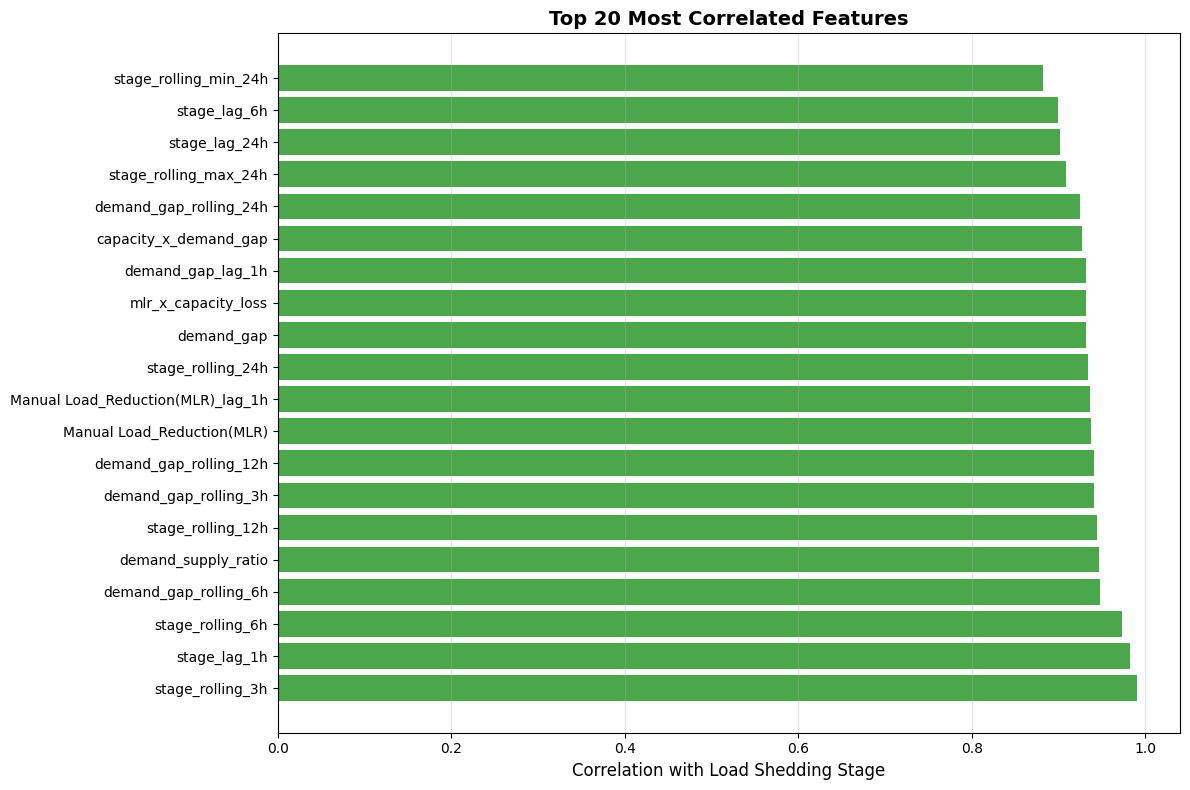


✅ Feature importance visualization saved


In [ ]:
print("\n" + "="*70)
print("FEATURE IMPORTANCE PREVIEW")
print("="*70)

print("\n Top 15 features correlated with 'stage':")
correlations = df.corr()['stage'].sort_values(ascending=False)
print(correlations[1:16])  # Skip 'stage' itself

# Visualize top correlations
plt.figure(figsize=(12, 8))
top_corr = correlations[1:21]  # Top 20
colors = ['green' if x > 0 else 'red' for x in top_corr.values]
plt.barh(range(len(top_corr)), top_corr.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_corr)), top_corr.index, fontsize=10)
plt.xlabel('Correlation with Load Shedding Stage', fontsize=12)
plt.title('Top 20 Most Correlated Features', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(f'{output_dir}/05_feature_importance_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Feature importance visualization saved")


# EXPORT FEATURED DATA

In [ ]:
print("\n" + "="*70)
print("EXPORTING FEATURED DATA")
print("="*70)

# Save full featured dataset
output_path = f'{data_dir}/featured_data.csv'
df.to_csv(output_path, index=False)

print(f"\n✅ Featured dataset saved: {output_path}")
print(f"   Size: {len(df):,} rows × {len(df.columns)} columns")
print(f"   File size: {pd.read_csv(output_path).memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Create feature list with categories
feature_categories = {
    'Original': list(df.columns[:17]),
    'Lag': [col for col in df.columns if '_lag_' in col],
    'Rolling': [col for col in df.columns if '_rolling_' in col],
    'Temporal': [col for col in df.columns if col in ['hour', 'day_of_week', 'month', 'is_weekend',
                 'is_peak_hour', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin',
                 'day_cos', 'quarter', 'week_of_year', 'is_peak_morning', 'is_peak_evening',
                 'day_of_month']],
    'Interaction': [col for col in df.columns if any(x in col for x in ['_x_', '_ratio'])],
    'Statistical': [col for col in df.columns if any(x in col for x in ['_std_', '_change_', '_max_', '_min_'])]
}

# Save feature list with categories
features_path = f'{data_dir}/feature_list_detailed.txt'
with open(features_path, 'w') as f:
    f.write("FEATURE ENGINEERING SUMMARY\n")
    f.write("="*70 + "\n\n")
    f.write(f"Total Features: {total_features}\n")
    f.write(f"Dataset: {len(df):,} rows\n\n")

    for category, features in feature_categories.items():
        f.write(f"\n{category} Features ({len(features)}):\n")
        f.write("-" * 50 + "\n")
        for i, feature in enumerate(features, 1):
            f.write(f"  {i:2d}. {feature}\n")

print(f"✅ Detailed feature list saved: {features_path}")



EXPORTING FEATURED DATA

✅ Featured dataset saved: /content/drive/MyDrive/LoadShedding_Capstone/data/featured_data.csv
   Size: 36,143 rows × 86 columns
   File size: 25.78 MB
✅ Detailed feature list saved: /content/drive/MyDrive/LoadShedding_Capstone/data/feature_list_detailed.txt
